In [10]:
import os
import nni
import yaml
import argparse
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from UCTB.dataset import DataSet

from UCTB.dataset import NodeTrafficLoader
from UCTB.model import STMeta
from UCTB.evaluation import metric
from UCTB.preprocess.time_utils import is_work_day_china, is_work_day_america

from UCTB.preprocess.GraphGenerator import GraphGenerator
from UCTB.preprocess import Normalizer, SplitData

In [11]:
inflow_loader = NodeTrafficLoader(dataset="Metro",city="Shanghai_Inflow")

In [12]:
inflow_loader.train_y.shape

(8054, 287, 1)

In [15]:
inflow_loader.traffic_data.shape

(16416, 287)

In [3]:
outflow_loader = NodeTrafficLoader(dataset="Metro",city="Shanghai_Outflow")

traffic (16416, 287)
test: (1642, 287)
train: (14774, 287)
test: (8362, 287)


In [4]:
inflow_loader.dataset.time_range

['2016-07-01', '2016-09-14']

In [117]:
inflow_loader.dataset.node_traffic.shape

(16416, 288)

In [5]:
def showStation(traffic,offset,showdays,stationNum,fitness=5, newfigure=False):
    if newfigure:
        plt.figure(figsize=(20,8))
    offset *= (60//fitness)*24
    offset = int(offset)
    x =traffic[(0+offset):int((60//fitness)*24*showdays+offset),stationNum]
    plt.plot(list(range(len(x))),x)

In [6]:
in_traffic = inflow_loader.traffic_data
out_traffic = outflow_loader.traffic_data

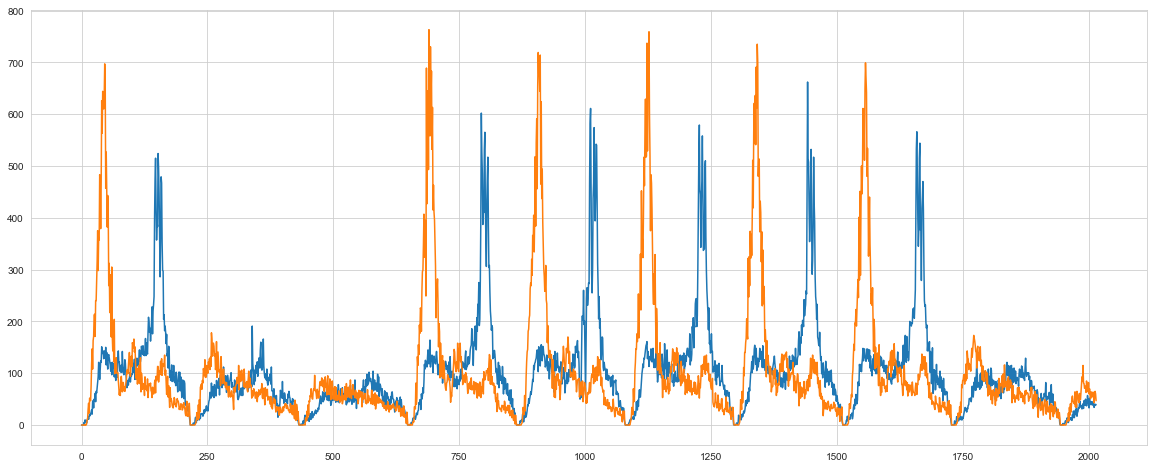

In [7]:
offset = 0
showdays = 7
fitness = 5 # mins
stationNum = 149
plt.figure(figsize=(20,8))
showStation(in_traffic,offset,showdays,stationNum,fitness=fitness)
showStation(out_traffic,offset,showdays,stationNum,fitness=fitness)
# 同一站点的inflow 和outflow展现出明显的pattern

In [132]:
# merge into one dataset
merge_flow = np.concatenate([inflow_loader.dataset.data["Node"]["TrafficNode"][:,:,np.newaxis],outflow_loader.dataset.data["Node"]["TrafficNode"][:,:,np.newaxis]],axis=-1)
print("merge flow is:", merge_flow.shape)

merge flow is: (16416, 288, 2)


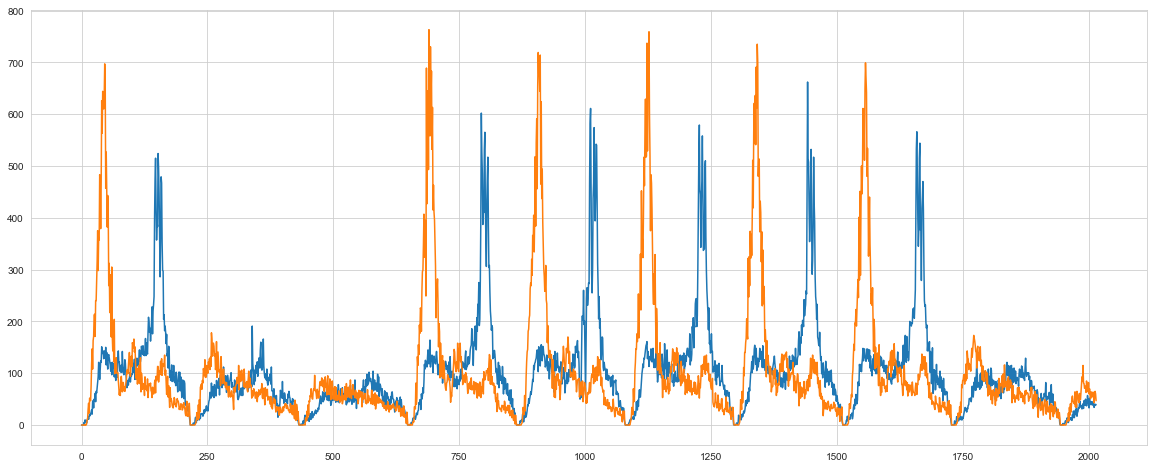

In [133]:
offset = 0
showdays = 7
fitness = 5 # mins
stationNum = 149
plt.figure(figsize=(20,8))
showStation(merge_flow[:,:,0],offset,showdays,stationNum,fitness=fitness)
showStation(merge_flow[:,:,1],offset,showdays,stationNum,fitness=fitness)
# 同一站点的inflow 和outflow展现出明显的pattern

In [8]:
StationInfo = inflow_loader.dataset.data['Node']['StationInfo']

In [9]:
StationInfo

[['0', '0101-0501', 31.111193, 121.385379, '1号线莘庄'],
 ['1', '0102', 31.120899, 121.39302, '1号线外环路'],
 ['2', '0103', 31.130986, 121.402943, '1号线莲花路'],
 ['3', '0104', 31.142217, 121.414107, '1号线锦江乐园'],
 ['4', '0105-0301', 31.154579, 121.430041, '1号线上海南站', '3号线上海南站'],
 ['5', '0106-1225', 31.168338, 121.433141, '1号线漕宝路'],
 ['6', '0107-0426E', 31.182813, 121.437423, '1号线上海体育馆', '4号线上海体育馆'],
 ['7', '0108-0917-1114', 31.195338, 121.436837, '1号线徐家汇', '9号线徐家汇'],
 ['8', '0109', 31.204528, 121.446424, '1号线衡山路'],
 ['9', '0110-0720', 31.213524, 121.449141, '1号线常熟路', '7号线常熟路'],
 ['10', '0111-1017-1219', 31.21515, 121.458744, '10号线陕西南路', '1号线陕西南路'],
 ['11', '0112', 31.222745, 121.473306, '1号线黄陂南路'],
 ['12', '0113-0212-0815', 31.23273, 121.47564, '1号线人民广场', '8号线人民广场'],
 ['13', '0114', 31.238373, 121.468151, '1号线新闸路'],
 ['14', '0115-1217-1312', 31.241883, 121.458699, '1号线汉中路'],
 ['15', '0116-0313-0409', 31.249538, 121.458219, '1号线上海火车站', '3号线上海火车站'],
 ['16', '0117', 31.258891, 121.459204, '1号线中山北路'],
 

In [10]:
station_name_ls = []
for x in StationInfo:
    station_name_ls += x[4:]

In [11]:
import re
pattern = "\d+号线"
lines_names = np.unique([re.match(pattern, x).group() for x in station_name_ls])
lines_names.sort()

In [12]:
lines_names

array(['10号线', '11号线', '12号线', '13号线', '16号线', '1号线', '2号线', '3号线', '4号线',
       '5号线', '6号线', '7号线', '8号线', '9号线'], dtype='<U4')

In [13]:
lat_ls = [x[2] for x in StationInfo]
lng_ls = [x[3] for x in StationInfo]

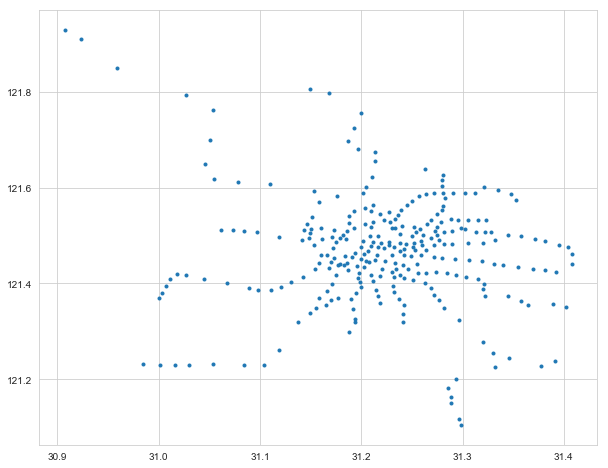

In [14]:
plt.figure(figsize=(10,8))
plt.plot(lat_ls,lng_ls,'.')

In [ ]:
'''
1号地铁时刻表

车站    首班车    常态末班车发车时刻（周日-周四）    延时运营末班车发车时刻（周五-周六）    
往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    
莘庄    05:30    05:30    06:04(到达)    22:32    22:32    23:34(到达)    23:50    23:50    次00:54(到达)    
外环路    05:32    05:32    06:02    22:34    22:34    23:32    23:52    23:52    次00:52    
莲花路    05:34    05:34    06:00    22:36    22:36    23:30    23:54    23:54    次00:50    
锦江乐园    05:37    05:37    05:57    22:39    22:39    23:27    23:57    23:57    次00:47    
上海南站    05:18    04:55    05:54    22:42    22:42    23:24    次00:00    次00:00    次00:44    
漕宝路    05:20    04:57    05:51    22:45    22:45    23:21    次00:03    次00:03    次00:41    
上海体育馆    05:23    05:00    05:49    22:48    22:48    23:19    次00:06    次00:06    次00:39    
徐家汇    05:25    05:02    05:46    22:50    22:50    23:16    次00:08    次00:08    次00:36    
衡山路    05:27    05:04    05:44    22:52    22:52    23:14    次00:10    次00:10    次00:34    
常熟路    05:29    05:06    05:42    22:54    22:54    23:12    次00:12    次00:12    次00:32    
陕西南路    05:31    05:08    05:40    22:56    22:56    23:10    次00:14    次00:14    次00:30    
黄陂南路    05:34    05:11    05:38    22:58    22:58    23:08    次00:16    次00:16    次00:28    
人民广场    05:37    05:14    05:35    23:01    23:01    23:05    次00:19    次00:19    次00:25    
新闸路    05:38    05:15    05:33    23:03    23:03    23:03    次00:21    次00:21    次00:23    
汉中路    05:40    05:17    05:31    23:05    23:05    23:01    次00:23    次00:23    次00:21    
上海火车站    05:43    05:19(到达)    05:30    23:08    23:08    23:00    次00:26    次00:26    次00:20    
中山北路    05:45    --    05:57    23:10    --    22:57    次00:28    --    次00:17    
延长路    05:48    --    05:55    23:13    --    22:55    次00:31    --    次00:15    
上海马戏城    05:50    --    05:53    23:15    --    22:53    次00:33    --    次00:13    
汶水路    05:52    --    05:50    23:17    --    22:50    次00:35    --    次00:10    
彭浦新村    05:55    --    05:47    23:20    --    22:47    次00:38    --    次00:07    
共康路    05:58    --    05:45    23:23    --    22:45    次00:41    --    次00:05    
通河新村    06:00    --    05:42    23:25    --    22:42    次00:43    --    次00:02    
呼兰路    06:03    --    05:40    23:27    --    22:40    次00:45    --    次00:00    
共富新村    06:05    --    05:37    23:30    --    22:37    次00:48    --    23:57    
宝安公路    06:08    --    05:34    23:33    --    22:34    次00:51    --    23:54    
友谊西路    06:10    --    05:32    23:35    --    22:32    次00:53    --    23:52    
富锦路    06:12(到达)    --    05:30    23:37(到达)    --    22:30    次00:55(到达)    --    23:50    

周一　～　周四    
名称    时段    列车间隔    
莘庄～上海火车站    上海火车站～富锦路    
早高峰    7:00～9:00    平均2分30秒    
平峰    9:00～17:00    平均4分    平均6分    
晚高峰    17:00～19:00    平均3分    
其余时段    4分 ～?9分    
周五    
名称    时段    列车间隔    
莘庄～上海火车站    上海火车站～富锦路    
早高峰    7:00～9:00    平均2分30秒    
平峰    9:00～14:30    平均4分    平均6分    
晚高峰    14:30～17:00    平均4分    
17:00～19:00    平均3分    
其余时段    4分～9分    
周六、周日    
名称    时段    列车间隔    
莘庄～上海火车站    上海火车站～富锦路    
高峰时段    9:00～20:00    平均4分    
其余时段    6分～12分    
延时运营列车间隔（周五、周六）    
名称    时段    列车间隔    
莘庄～富锦路    
延时运营    22:30～运营结束    10分～16分    
'''

# generate static graph

In [2]:
import pandas as pd
import dateutil

In [170]:
#line_path = os.path.abspath("/Users/chenliyue/Documents/GitHub/dynamic-graph/line1.xlsx")
line_path = os.path.join(os.getcwd(),"line1.xlsx")

In [177]:
line_data = pd.read_excel(line_path)

In [178]:
line_width = {}
for x in line_data.columns:
    if isinstance(x,int):
        curr_line = x
        count = 1
    else:
        count += 1
    line_width[curr_line] = count
accumulate = 0
for key in line_width.keys():
    tmp = line_width[key]
    line_width[key] = [accumulate,accumulate + tmp]
    accumulate += tmp
line_data.columns = [x for x in range(len(line_data.columns))]

In [179]:
def meanless_transform(time_data):
    try:
        return dateutil.parser.parse(time_data.strftime("%H:%M:%S"))
    except Exception as e:
        time_data = time_data.replace("(到达)","")
        return dateutil.parser.parse(time_data)

In [180]:
def checkCol_ADD(df,row,col):
    return bool(1-pd.isna(df.iloc[row][col])) and bool(1-pd.isna(df.iloc[row+1][col]))

def checkFlag(delta, flag): 
    if delta.days == 0:
        tmp_flag = True
    else:
        tmp_flag = False    
    if flag == tmp_flag:
        return True
    else:
        return False


def trans_every_col(Acol_tmp,line_num):
    # Acol_tmp should be (n,2) and it should look like
    #0 往富锦路 往莘庄
    #1 莘庄 05:30:00
    #2 外环路 05:32:00
    triple = []
    ii = 1
    while(pd.isna(Acol_tmp.iloc[ii][1])):
        ii += 1
    delta = meanless_transform(Acol_tmp.iloc[ii+1][1]) - meanless_transform(Acol_tmp.iloc[ii][1])
    if delta.days == 0:
        increase_flag = True
    else:
        increase_flag = False

    for ind in range(1,Acol_tmp.shape[0]-1):
        if checkCol_ADD(Acol_tmp,ind,0):
            if checkCol_ADD(Acol_tmp,ind,1):
                try:
                    delta = meanless_transform(Acol_tmp.iloc[ind+1][1]) - meanless_transform(Acol_tmp.iloc[ind][1])
                    if checkFlag(delta, increase_flag):
                        if increase_flag:
                            result = meanless_transform(Acol_tmp.iloc[ind+1][1]) - meanless_transform(Acol_tmp.iloc[ind][1])
                        else:
                            result = meanless_transform(Acol_tmp.iloc[ind][1]) - meanless_transform(Acol_tmp.iloc[ind+1][1])
                        
                        temp_info = ["{}号线{}".format(line_num,Acol_tmp.iloc[ind][0]),"{}号线{}".format(line_num,Acol_tmp.iloc[ind+1][0]),str(result.seconds)]
                        triple.append(temp_info)
                        print(" ".join(temp_info))
                except Exception as e:
                    print("************************************************")
                    print(e)
                    print(Acol_tmp.iloc[ind][1],Acol_tmp.iloc[ind+1][1])
                    print("************************************************")
    return triple
        

In [181]:
triple_ls = []
for key in line_width.keys():
    left = line_width[key][0]
    right = line_width[key][1]
    num_cols = right - left
    for ind in range(1, num_cols):
        try:
            Acol_tmp = line_data[[left,left+ind]].copy()
            Acol_tmp.columns = [x for x in range(len(Acol_tmp.columns))]
            triple_ls += trans_every_col(Acol_tmp, key)
        except Exception as e:
            print(e)
            print("key is:" ,key)
            print("range is :",left,left+ind)


1号线莘庄 1号线外环路 120
1号线外环路 1号线莲花路 120
1号线莲花路 1号线锦江乐园 180
1号线上海南站 1号线漕宝路 120
1号线漕宝路 1号线上海体育馆 180
1号线上海体育馆 1号线徐家汇 120
1号线徐家汇 1号线衡山路 120
1号线衡山路 1号线常熟路 120
1号线常熟路 1号线陕西南路 120
1号线陕西南路 1号线黄陂南路 180
1号线黄陂南路 1号线人民广场 180
1号线人民广场 1号线新闸路 60
1号线新闸路 1号线汉中路 120
1号线汉中路 1号线上海火车站 180
1号线上海火车站 1号线中山北路 120
1号线中山北路 1号线延长路 180
1号线延长路 1号线上海马戏城 120
1号线上海马戏城 1号线汶水路 120
1号线汶水路 1号线彭浦新村 180
1号线彭浦新村 1号线共康路 180
1号线共康路 1号线通河新村 120
1号线通河新村 1号线呼兰路 180
1号线呼兰路 1号线共富新村 120
1号线共富新村 1号线宝安公路 180
1号线宝安公路 1号线友谊西路 120
1号线友谊西路 1号线富锦路 120
1号线莘庄 1号线外环路 120
1号线外环路 1号线莲花路 120
1号线莲花路 1号线锦江乐园 180
1号线上海南站 1号线漕宝路 120
1号线漕宝路 1号线上海体育馆 180
1号线上海体育馆 1号线徐家汇 120
1号线徐家汇 1号线衡山路 120
1号线衡山路 1号线常熟路 120
1号线常熟路 1号线陕西南路 120
1号线陕西南路 1号线黄陂南路 180
1号线黄陂南路 1号线人民广场 180
1号线人民广场 1号线新闸路 60
1号线新闸路 1号线汉中路 120
1号线汉中路 1号线上海火车站 120
2号线徐泾东 2号线虹桥火车站 120
2号线虹桥火车站 2号线虹桥2号航站楼 120
2号线虹桥2号航站楼 2号线淞虹路 420
2号线淞虹路 2号线北新泾 180
2号线北新泾 2号线威宁路 120
2号线威宁路 2号线娄山关路 180
2号线娄山关路 2号线中山公园 180
2号线中山公园 2号线江苏路 180
2号线江苏路 2号线静安寺 180
2号线静安寺 2号线南京西路 120
2号线南京西路 2号线人民广场 120
2号线人民广场 2号线南京东路 180
2

10号线五角场 10号线江湾体育场 60
10号线江湾体育场 10号线三门路 120
10号线三门路 10号线殷高东路 120
10号线殷高东路 10号线新江湾城 120
10号线虹桥火车站 10号线虹桥2号航站楼 60
10号线虹桥2号航站楼 10号线虹桥1号航站楼 180
10号线虹桥1号航站楼 10号线上海动物园 180
10号线上海动物园 10号线龙溪路 120
10号线龙溪路 10号线水城路 120
10号线水城路 10号线伊犁路 120
10号线伊犁路 10号线宋园路 120
10号线宋园路 10号线虹桥路 120
10号线虹桥路 10号线交通大学 180
10号线交通大学 10号线上海图书馆 120
10号线上海图书馆 10号线陕西南路 120
10号线陕西南路 10号线新天地 180
10号线新天地 10号线老西门 120
10号线老西门 10号线豫园 180
10号线豫园 10号线南京东路 120
10号线南京东路 10号线天潼路 120
10号线天潼路 10号线四川北路 120
10号线四川北路 10号线海伦路 120
10号线海伦路 10号线邮电新村 120
10号线邮电新村 10号线四平路 120
10号线四平路 10号线同济大学 120
10号线同济大学 10号线国权路 120
10号线国权路 10号线五角场 120
10号线五角场 10号线江湾体育场 60
10号线江湾体育场 10号线三门路 120
10号线三门路 10号线殷高东路 120
10号线殷高东路 10号线新江湾城 120
10号线航中路 10号线紫藤路 180
10号线紫藤路 10号线龙柏新村 120
10号线龙溪路 10号线水城路 120
10号线水城路 10号线伊犁路 180
10号线伊犁路 10号线宋园路 60
10号线宋园路 10号线虹桥路 120
10号线虹桥路 10号线交通大学 180
10号线交通大学 10号线上海图书馆 120
10号线上海图书馆 10号线陕西南路 120
10号线陕西南路 10号线新天地 180
10号线新天地 10号线老西门 120
10号线老西门 10号线豫园 120
10号线豫园 10号线南京东路 120
10号线南京东路 10号线天潼路 180
10号线天潼路 10号线四川北路 120
10号线四川北路 10号线海伦路 120
10号

In [154]:
pd.DataFrame(triple_ls,columns=["start",'end',"duration"]).to_csv("triple.csv",index=False,encoding="")

# transform triple

In [27]:
import pandas as pd
import dateutil
import re

In [16]:
path = os.path.join(os.getcwd(),"triple.csv")
triple_data = pd.read_csv(path)

In [17]:
triple_data.head()

,start,end,duration
0,1号线莘庄,1号线外环路,120
1,1号线外环路,1号线莲花路,120
2,1号线莲花路,1号线锦江乐园,180
3,1号线上海南站,1号线漕宝路,120
4,1号线漕宝路,1号线上海体育馆,180


In [101]:

def remove_line_num(string):
    pattern = "\d+号线"
    return re.sub(r"\d+号线","",string)
lines_names_remove_num = [remove_line_num(x[4]) for x in StationInfo]

In [102]:
name2index = {}
for ind,x in enumerate(lines_names_remove_num):
    x = x.strip()
    if x == "上海大学站":
        name2index["上海大学"] = ind 
    elif x == "上海野生动物园":
        name2index["野生动物园"] = ind 
    elif x == "李子园路":
        name2index["李子园"] = ind 
    elif x == "外高桥保税区北":
        name2index["外高桥保税区北站"] = ind 
    elif x == "外高桥保税区南":
        name2index["外高桥保税区南站"] = ind 
    else:
        name2index[x] = ind

In [103]:
name2index

{'莘庄': 0,
 '外环路': 1,
 '莲花路': 2,
 '锦江乐园': 3,
 '上海南站': 4,
 '漕宝路': 5,
 '上海体育馆': 6,
 '徐家汇': 7,
 '衡山路': 8,
 '常熟路': 9,
 '陕西南路': 10,
 '黄陂南路': 11,
 '人民广场': 12,
 '新闸路': 13,
 '汉中路': 14,
 '上海火车站': 15,
 '中山北路': 16,
 '延长路': 17,
 '上海马戏城': 18,
 '汶水路': 19,
 '彭浦新村': 20,
 '共康路': 21,
 '通河新村': 22,
 '呼兰路': 23,
 '共富新村': 24,
 '宝安公路': 25,
 '友谊西路': 26,
 '富锦路': 27,
 '徐泾东': 28,
 '虹桥火车站': 29,
 '虹桥2号航站楼': 30,
 '淞虹路': 31,
 '北新泾': 32,
 '威宁路': 33,
 '娄山关路': 34,
 '中山公园': 35,
 '江苏路': 36,
 '静安寺': 37,
 '南京西路': 38,
 '南京东路': 39,
 '陆家嘴': 40,
 '东昌路': 41,
 '世纪大道': 42,
 '上海科技馆': 43,
 '世纪公园': 44,
 '龙阳路': 45,
 '张江高科': 46,
 '金科路': 47,
 '广兰路': 48,
 '唐镇': 49,
 '创新中路': 50,
 '华夏东路': 51,
 '川沙': 52,
 '凌空路': 53,
 '远东大道': 54,
 '海天三路': 55,
 '浦东国际机场': 56,
 '石龙路': 57,
 '龙漕路': 58,
 '漕溪路': 59,
 '宜山路': 60,
 '虹桥路': 61,
 '延安西路': 62,
 '金沙江路': 63,
 '曹杨路': 64,
 '镇坪路': 65,
 '中潭路': 66,
 '宝山路': 67,
 '东宝兴路': 68,
 '虹口足球场': 69,
 '赤峰路': 70,
 '大柏树': 71,
 '江湾镇': 72,
 '殷高西路': 73,
 '长江南路': 74,
 '淞发路': 75,
 '张华浜': 76,
 '淞浜路': 77,
 '水产路': 78,
 '宝杨路': 79,
 '友谊路':

In [104]:
graph = np.zeros((len(StationInfo),len(StationInfo)))
not_fount_station = []
for i in range(triple_data.shape[0]):
    try:
        tmp = triple_data.iloc[i]
        #graph[name2index[tmp['start']]][name2index[tmp['end']]] = int(tmp['duration'])
        graph[name2index[remove_line_num(tmp['start'])]][name2index[remove_line_num(tmp['end'])]] = int(tmp['duration'])
    except Exception as e:
        not_fount_station.append(e)
        #print("*******************************")
        #print("key is: ", e)
        #print("pair is: ",remove_line_num(tmp['start']),remove_line_num(tmp['end']))
        #print("*******************************")
not_fount_station = list(np.unique([x.args[0] for x in not_fount_station]))

In [105]:
print(not_fount_station)

['七莘路', '下南路', '世博会博物馆', '世博大道', '东兰路', '中科路', '北蔡', '华鹏路', '奉浦大道', '学林路', '康新公路', '望园路', '桂林公园', '江宁路', '江川路', '淞滨路', '淮海中路', '环城东路', '秀沿路', '自然博物馆', '莲溪路', '萧塘', '虹梅路', '虹漕路', '虹莘路', '西渡', '金海湖', '陈春路', '顾戴路']


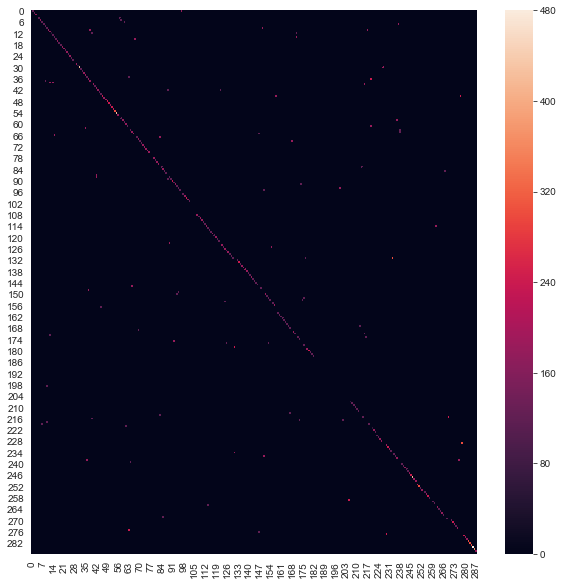

In [112]:
start = 0
duration = 288
plt.figure(figsize=(10,10))
show = graph[start:start+duration][:]
show = graph[:][start:start+duration]
sns.heatmap(show,annot=False)

In [136]:
graph.max()

480.0

In [137]:
name2index

{'莘庄': 0,
 '外环路': 1,
 '莲花路': 2,
 '锦江乐园': 3,
 '上海南站': 4,
 '漕宝路': 5,
 '上海体育馆': 6,
 '徐家汇': 7,
 '衡山路': 8,
 '常熟路': 9,
 '陕西南路': 10,
 '黄陂南路': 11,
 '人民广场': 12,
 '新闸路': 13,
 '汉中路': 14,
 '上海火车站': 15,
 '中山北路': 16,
 '延长路': 17,
 '上海马戏城': 18,
 '汶水路': 19,
 '彭浦新村': 20,
 '共康路': 21,
 '通河新村': 22,
 '呼兰路': 23,
 '共富新村': 24,
 '宝安公路': 25,
 '友谊西路': 26,
 '富锦路': 27,
 '徐泾东': 28,
 '虹桥火车站': 29,
 '虹桥2号航站楼': 30,
 '淞虹路': 31,
 '北新泾': 32,
 '威宁路': 33,
 '娄山关路': 34,
 '中山公园': 35,
 '江苏路': 36,
 '静安寺': 37,
 '南京西路': 38,
 '南京东路': 39,
 '陆家嘴': 40,
 '东昌路': 41,
 '世纪大道': 42,
 '上海科技馆': 43,
 '世纪公园': 44,
 '龙阳路': 45,
 '张江高科': 46,
 '金科路': 47,
 '广兰路': 48,
 '唐镇': 49,
 '创新中路': 50,
 '华夏东路': 51,
 '川沙': 52,
 '凌空路': 53,
 '远东大道': 54,
 '海天三路': 55,
 '浦东国际机场': 56,
 '石龙路': 57,
 '龙漕路': 58,
 '漕溪路': 59,
 '宜山路': 60,
 '虹桥路': 61,
 '延安西路': 62,
 '金沙江路': 63,
 '曹杨路': 64,
 '镇坪路': 65,
 '中潭路': 66,
 '宝山路': 67,
 '东宝兴路': 68,
 '虹口足球场': 69,
 '赤峰路': 70,
 '大柏树': 71,
 '江湾镇': 72,
 '殷高西路': 73,
 '长江南路': 74,
 '淞发路': 75,
 '张华浜': 76,
 '淞浜路': 77,
 '水产路': 78,
 '宝杨路': 79,
 '友谊路':

In [114]:
StationInfo

[['0', '0101-0501', 31.111193, 121.385379, '1号线莘庄'],
 ['1', '0102', 31.120899, 121.39302, '1号线外环路'],
 ['2', '0103', 31.130986, 121.402943, '1号线莲花路'],
 ['3', '0104', 31.142217, 121.414107, '1号线锦江乐园'],
 ['4', '0105-0301', 31.154579, 121.430041, '1号线上海南站', '3号线上海南站'],
 ['5', '0106-1225', 31.168338, 121.433141, '1号线漕宝路'],
 ['6', '0107-0426E', 31.182813, 121.437423, '1号线上海体育馆', '4号线上海体育馆'],
 ['7', '0108-0917-1114', 31.195338, 121.436837, '1号线徐家汇', '9号线徐家汇'],
 ['8', '0109', 31.204528, 121.446424, '1号线衡山路'],
 ['9', '0110-0720', 31.213524, 121.449141, '1号线常熟路', '7号线常熟路'],
 ['10', '0111-1017-1219', 31.21515, 121.458744, '10号线陕西南路', '1号线陕西南路'],
 ['11', '0112', 31.222745, 121.473306, '1号线黄陂南路'],
 ['12', '0113-0212-0815', 31.23273, 121.47564, '1号线人民广场', '8号线人民广场'],
 ['13', '0114', 31.238373, 121.468151, '1号线新闸路'],
 ['14', '0115-1217-1312', 31.241883, 121.458699, '1号线汉中路'],
 ['15', '0116-0313-0409', 31.249538, 121.458219, '1号线上海火车站', '3号线上海火车站'],
 ['16', '0117', 31.258891, 121.459204, '1号线中山北路'],
 

In [186]:
triple_unique_name = set(data['start'])
triple_unique_name = list(triple_unique_name.union(set(data['end'])))
print("There are {} different name".format(len(triple_unique_name)))

There are 394 different name


In [145]:
graph

numpy.ndarray

In [147]:
# create new dataset
import pickle as pkl
merge_dataset = inflow_loader.dataset.data.copy()
merge_dataset['Node']['TrafficNode'] = merge_flow
merge_dataset["contribute_data"]["graph_static_calendar"] = graph

In [150]:
with open("Metro_Shanghai_IOFLOW.pkl","wb") as fp:
    pkl.dump(merge_dataset,fp)

In [151]:
with open("Metro_Shanghai_IOFLOW.pkl","rb") as fp:
    merge_dataset = pkl.load(fp)

In [152]:
merge_dataset

{'Node': {'TrafficNode': array([[[  3.,   1.],
          [  0.,   0.],
          [  0.,   0.],
          ...,
          [  0.,   0.],
          [  0.,   0.],
          [  0.,   0.]],
  
         [[  5.,   0.],
          [  0.,   0.],
          [  5.,   0.],
          ...,
          [  0.,   0.],
          [  0.,   1.],
          [  0.,   0.]],
  
         [[ 18.,   0.],
          [  0.,   0.],
          [  5.,   1.],
          ...,
          [  0.,   2.],
          [  0.,   0.],
          [  0.,   0.]],
  
         ...,
  
         [[  0., 120.],
          [  0.,  30.],
          [  1., 225.],
          ...,
          [  0.,  24.],
          [  0.,   8.],
          [  0.,   0.]],
  
         [[  0., 346.],
          [  1.,  21.],
          [  0.,  79.],
          ...,
          [  0.,  15.],
          [  0.,   5.],
          [  0.,  12.]],
  
         [[  2., 141.],
          [  0.,  29.],
          [  2.,  72.],
          ...,
          [  1.,   6.],
          [  0.,   2.],
          

# crawl

In [56]:
import requests
from pyquery import PyQuery

template = 'http://sh.bendibao.com/ditie/shike_{param}.shtml'
page = 1
url = template.format(param = (page + 222))
resp = requests.get(url = url ,  headers={
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) '
                  'AppleWebKit/537.36 (KHTML, like Gecko) '
                  'Chrome/83.0.4103.97 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;'
              'q=0.9,image/webp,image/apng,*/*;'
              'q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'zh-CN,zh;q=0.9,en;q=0.8',
})

In [58]:
pq = PyQuery(resp.text)

In [72]:
item0 = PyQuery(resp.text)
item1 = item0('table tbody tr').items()
for it1 in item1:
    item2 = it1('td').items()
    for it2 in item2:
        string = it2.text()
        print(str(string).replace('\n', '') + '    ',end="")
    print('\n',end="")
print('\n\n',end="")

车站    首班车    常态末班车发车时刻（周日-周四）    延时运营末班车发车时刻（周五-周六）    
往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    往富锦路    往上海站    往莘庄    
莘庄    05:30    05:30    06:04(到达)    22:32    22:32    23:34(到达)    23:50    23:50    次00:54(到达)    
外环路    05:32    05:32    06:02    22:34    22:34    23:32    23:52    23:52    次00:52    
莲花路    05:34    05:34    06:00    22:36    22:36    23:30    23:54    23:54    次00:50    
锦江乐园    05:37    05:37    05:57    22:39    22:39    23:27    23:57    23:57    次00:47    
上海南站    05:18    04:55    05:54    22:42    22:42    23:24    次00:00    次00:00    次00:44    
漕宝路    05:20    04:57    05:51    22:45    22:45    23:21    次00:03    次00:03    次00:41    
上海体育馆    05:23    05:00    05:49    22:48    22:48    23:19    次00:06    次00:06    次00:39    
徐家汇    05:25    05:02    05:46    22:50    22:50    23:16    次00:08    次00:08    次00:36    
衡山路    05:27    05:04    05:44    22:52    22:52    23:14    次00:10    次00:10    次00:34    
常熟路    05:29    05:06    05:42    22:54

# loading new dataset

In [1]:
import os
import nni
import yaml
import argparse
import GPUtil
import numpy as np
from UCTB.dataset import DataSet

from UCTB.dataset import NodeTrafficLoader
from UCTB.model import STMeta
from UCTB.evaluation import metric
from UCTB.preprocess.time_utils import is_work_day_china, is_work_day_america

from UCTB.preprocess.GraphGenerator import GraphGenerator
from UCTB.preprocess import Normalizer, SplitData

Using TensorFlow backend.


In [2]:
data_loader = NodeTrafficLoader(dataset="Metro",city="Shanghai_IOFLOW",closeness_len="6",period_len="0",trend_len="0",data_range=[0,2])

In [ ]:
data_loader

In [3]:
data_loader.traffic_data.shape

(480, 287, 2)

In [4]:
data_loader.train_closeness.shape

(426, 287, 6, 2)

In [5]:
data_loader.train_sequence_len

426

In [6]:
data_loader.test_sequence_len

48

In [7]:
graph_obj = GraphGenerator(graph= "static",
                           data_loader=data_loader,
                           threshold_distance=5000,
                           threshold_correlation=0.7,
                           threshold_interaction=30)

In [8]:
graph_obj.train_dynamic.shape

(426, 287, 287, 6)

In [9]:
426*287*287*6*4 /1024/1024

803.1279144287109

In [10]:
graph_obj.test_dynamic.shape

(48, 287, 287, 6)

In [11]:
1684281456 /1024/1024/1024

1.5686093419790268

In [15]:
graph_obj.train_dynamic.dtype

dtype('int16')

In [13]:
from sys import getsizeof
getsizeof(graph_obj.train_dynamic.copy())/1024/1024

401.56409454345703

In [7]:
data_loader.train_data[-30 * int(data_loader.daily_slots):].shape

(7200, 287, 2)

In [3]:
train_closeness, val_closeness = SplitData.split_data(data_loader.train_closeness, [0.9, 0.1])
train_period, val_period = SplitData.split_data(data_loader.train_period, [0.9, 0.1])
train_trend, val_trend = SplitData.split_data(data_loader.train_trend, [0.9, 0.1])
train_y, val_y = SplitData.split_data(data_loader.train_y, [0.9, 0.1])
train_ef, val_ef = SplitData.split_data(data_loader.train_ef, [0.9, 0.1])

In [3]:
data_loader.train_closeness.shape

(8054, 287, 6, 2)

In [4]:
data_loader.train_y.shape

(8054, 287, 2)

In [7]:
data_loader.traffic_data.shape

(16416, 287, 2)

In [8]:
data_loader.traffic_data.shape[-1]

2

In [9]:
data_loader.train_y.shape

(8054, 287, 2)

In [16]:
data_loader.dataset.data['contribute_data']['graph_static_calendar'].shape

(288, 288)

In [17]:
tmp = data_loader.dataset.data['contribute_data']['graph_static_calendar']

In [22]:
((0< tmp)&( tmp <= 300)).shape


(288, 288)

In [19]:
data_loader.traffic_data.shape

(16416, 287, 2)

In [20]:
data_loader.train_closeness.shape

(8054, 287, 6, 2)

In [21]:
data_loader.test_closeness.shape

(1642, 287, 6, 2)

In [23]:
test = np.zeros([16416,288,288,17],dtype=np.float32)

MemoryError: 

In [10]:
12*24*3*288*288*7*4/1024/1024/1024

1.8687744140625

In [9]:
12*24*7*288*288*7*2/1024/1024/1024

2.18023681640625

In [24]:
12*24*71

20448

In [25]:
12*24*60

17280

In [26]:
17280*288*288*4/1024/1024/1024

5.33935546875

In [27]:
17280*288*288*4/1024/1024/1024 * 7

37.37548828125